# Notebook 3: Partial Mean Estimation
_Bryan Graham - University of California - Berkeley_

(with assistance from Seongjoo Min)

_Ec 240a: Econometrics, Fall 2015_

In lecture we introduced the partial mean estimand as a generalization of "long" linear regression to settings where the conditional mean of $Y$ given the policy variable $X$ and control variables $W$ may be non-linear and/or non-separable. Newey (1994, _Econometric Theory_) introduced a kernel estimator for partial means for settings where both $X$ and $W$ are continuously valued. When $X$ is a binary "treatment" vs. "control" indicator many different partial mean estimators are available. Imbens (2004, _Review of Economics and Statistics_) and Imbens and Wooldridge (2009, _Journal of Economic Literature_) review the extensive literature on partial mean estimation for the binary $X$ case (My favorite estimator for the binary case can be found in Graham, Pinto and Egel (2011, _Review of Economic Studies_). Stata code for this procedure can be found at http://eml.berkeley.edu//~bgraham/Software/software.html).
<br>
<br>
In this notebook we will develop an example of partial mean estimation for the case where both $W$ and $X$ are discretely-valued. This is also the case emphasized in lecture. Our results will also be useful for the case where $W$ is continuously valued, but can be usefully coarsened or binned into a finite number of cells. That is where we can proceed "as if" W were discretely-valued.
<br>
<br>
In the specific example developed below our interest is in the average earnings associated with four different levels of schooling: dropout (DO), high school graduate (HS), completed some college  (SC), and college graduate (UG). We wish to compute these averages in a way which "controls for" systematic differences in AFQT scores. We bin AFQT into three terciles. Hence $E[Y | W, X]$ has $dim(X)\times dim(W) = K \times J = 4 \times 3 = 12$ points of support. We can compute this CEF by a least squares fit of Y onto a full set of dummy variables for each possible combination of schooling and AFQT bin. We can then recover the partial mean by averaging this estimated CEF over the marginal distribution of AFQT for fixed levels of schooling.
<br>
<br>
Our partial mean estimator is a two-step one. Both steps involve linear problems. Also, as shown in lecture, by appropriately organizing our data, the partial mean can be computed in one step by solving a single linear problem. This observation has a number of advantages. First, it means we can use standard software to compute the partial mean (in this case a linear instrumental variables program). Second, we can easily calculate standard errors which correctly account for the effect of first step sampling error on our final partial mean estimates. 
<br>
<br>
A larger theme I wish to emphasize is that there are often huge returns to thinking about how to set up your estimation problem. In the example below all the real work is in pre-processing and organizing the data -- actual computation is trivial. Nevertheless this is an example where many empirical researchers have struggled, for example, to compute standard errors that appropriately account for all sources of sampling error.

In [1]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import numpy as np
import numpy.linalg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
from __future__ import division

Although the statmodels library has an implementation of two-stage least squares, it has some features which appear suspicious to me. Many Python libraries are very much at the "beta" stage; a fact that one should be mindful of. The following snippet of code defines a function which computes the linear instrumental variables fit of Y onto X with Z serving as an instrument for the special case where $dim(X)=dim(Z)$. The function also returns "cluster-robust" standard errors, which will be useful for our purposes. We will use this function for partial mean computation below.

In [3]:
# Define function to compute a just-identified linear instrumental variables fit with clustered standard errors

def ivreg(Y,X,Z,c_id):
    
    # INPUTS:
    # Y = N X 1 numpy array of dependent variable
    # X = N X K numpy array of regressors
    # Z = N X J numpy array of instruments (J==K)
    # C = N X 1 numpy array of unique `cluster' id values
    
    # OUTPUTS:
    # beta_hat = K x 1 vector of linear IV estimates of beta
    # vcov_hat = K x K cluster-robust variance-covariance estimate
    # N        = number of unique clusters
    
    c_list = np.unique(c_id)            # Get unique list of clusters
    N      = len(c_list)                # Number of clusters
    J      = Z.shape[1]                 # Numer of instruments/moments
    
    # Compute beta_hat   
    ZX  = Z.T.dot(X)
    ZY  = Z.T.dot(Y)
    beta_hat = numpy.linalg.solve(ZX, ZY)
    
    # Compute estimate of variance-covariance matrix of the sample moment vector
    psi    = Z * (Y - X.dot(beta_hat))  # n x J matrix of moment vectors
       
    # Sum moment vector within clusters
    sum_psi = np.empty((N,J))
    
    for c in range(0,N):
        b_cluster = (c_id[:,0]==c_list[c])               # Indicator for given cluster value
        sum_psi[c,:] = np.sum(psi[b_cluster,:],axis=0)   # Sum over rows within c-th cluster
    
    # Compute variance-covariance matrix of beta_hat    
    omega = sum_psi.T.dot(sum_psi)         # J X J variance-covariance of the summed moments
    iZX   = np.linalg.inv(ZX)
    vcov_hat = iZX.dot(omega).dot(iZX.T)
    beta_hat = beta_hat.reshape(-1)        # Re-shape beta estimate to 1-dimensional array
 
    return [beta_hat,vcov_hat,N]

After loading the nlsy79.csv file created in Notebook 1 into our workspace, our first task is to visualize the joint distribution of schooling and AFQT percentile scores in our sample. We do this by computing the joint frequency distribution and using it to construct a "heatmap". The code which follows is similar to code which first appeared in Notebook 1.

Joint Frequency Distribution of Schooling and AFQT, NLSY79

AFQT Tercile     [0,33]  (33,66]  (66,100]  Pr(Sch=y)
Schooling Level                                      
DO                 9.70     2.18      0.20      12.09
HS                13.66    18.99      9.90      42.56
SC                 2.74     6.70     10.46      19.91
UG                 0.41     4.16     20.87      25.44
Pr(AFQT=x)        26.51    32.05     41.44     100.00


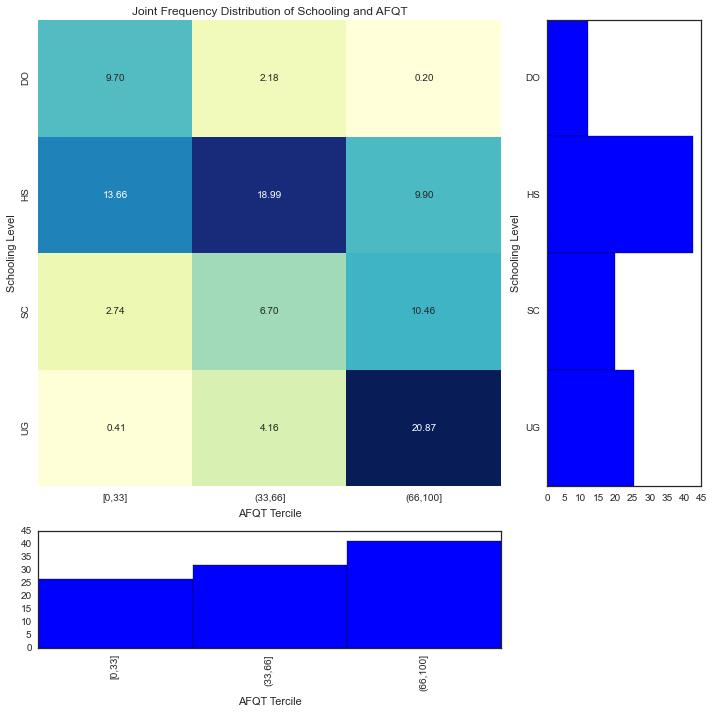

In [4]:
# Directory where nlsy79.csv file (created in Ec240a Python Notebook 1) is located
workdir =  '/Users/bgraham/Dropbox/Teaching/Teaching_Datasets/'

# Read in NLSY79 Extract
nlsy79 = pd.read_csv(workdir+'nlsy79.csv') 
nlsy79.describe()

# Divide AFQT percentile scores into three bins
afqt_bkts = [-1, 33, 66, 100]

# Define four years of completed schooling groupings
ed_bkts  = [-1, 11, 12, 15, 20]

# Create cross-tabulation of schooling and AFQT levels
sch_by_afqt = pd.crosstab(np.digitize(nlsy79.HGC_Age28, ed_bkts, right=True), \
                          np.digitize(nlsy79.AFQT, afqt_bkts, right=True), \
                          rownames=['Schooling'], colnames=['AFQT'], margins=True)

N = len(nlsy79.Earnings)                  # Total number of complete cases
sch_by_afqt = 100*sch_by_afqt/N           # Convert counts to percentages

# Create informative labels for bins and attach them to the cross tabulation 
afqt_bkt_labels = ['[0,33]', '(33,66]', '(66,100]', 'Pr(Sch=y)']
ed_bkt_labels = ['DO', 'HS', 'SC', 'UG', 'Pr(AFQT=x)'] 

# Associate bin labels with cross tabulation
sch_by_afqt.index = pd.Index(ed_bkt_labels, name="Schooling Level")
sch_by_afqt.columns = pd.Index(afqt_bkt_labels, name="AFQT Tercile")

print "Joint Frequency Distribution of Schooling and AFQT, NLSY79"
print ""
print np.round(sch_by_afqt,2)

# Form a plot with a heatmap of the joint frequency distribution at the center and histograms
# of the two marginal frequency distributions on each side.
import matplotlib.gridspec as gridspec

# Drop row and columns corresponding to margins
sch_by_afqt = sch_by_afqt.drop('Pr(AFQT=x)', 0)    # Drops AFQT margins
sch_by_afqt = sch_by_afqt.drop('Pr(Sch=y)', 1)     # Drops schooling margins

# Get marginal distributions of AFQT and schooling
mfd_afqt = sch_by_afqt.sum(axis=0)
mfd_sch = sch_by_afqt.sum(axis=1)

# Create figure; use gridspec to control relative size of three subplots
sch_by_afqt_fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[4,1]) 

# Joint frequency distribion
ax0 = plt.subplot(gs[0])
sns.set(style="white")
sns.heatmap(sch_by_afqt, cmap="YlGnBu", robust=True, annot=True, fmt=".2f", cbar=False)
plt.title('Joint Frequency Distribution of Schooling and AFQT')
plt.xlabel('AFQT Tercile')
plt.ylabel('Schooling Level')

# Marginal frequency distribution of earnings
ax1 = plt.subplot(gs[1])
mfd_sch.plot(kind='barh',width=1, facecolor='blue', edgecolor='black').invert_yaxis()
plt.autoscale()

# Marginal frequency distribution of schooling
ax2 = plt.subplot(gs[2])
mfd_afqt.plot(kind='bar',width=1, facecolor='blue', edgecolor='black')
plt.autoscale()

# Save result
plt.tight_layout()
plt.savefig(workdir+'Fig_jfd_sch_and_afqt.png')

# Create dummy variables for schooling and AFQT and attach them to nlsy79 dataframe
# Drop labels for margin columns from bucket label lists
ed_bkt_labels.pop(-1)
afqt_bkt_labels.pop(-1)

# Create dummy variables for education and AQFT categories
# Find education and AFQT group for each respondent
ed_bin = pd.cut(nlsy79.HGC_Age28, ed_bkts, right=True, include_lowest=True, labels = ed_bkt_labels)
afqt_bin = pd.cut(nlsy79.AFQT, afqt_bkts, right=True, include_lowest=True, labels = afqt_bkt_labels)

ed_dummies =  pd.get_dummies(ed_bin)
afqt_dummies =  pd.get_dummies(afqt_bin)

# Reconfigure dataframe to drop unnecessary variables and attach dummies
nlsy79 = nlsy79[["PID_79","HHID_79","Earnings", "AFQT"]].join([ed_dummies, afqt_dummies]) 

In inspecting the joint frequency distribution of schooling and AFQT we can observe strong dependencies across these two variables. Few respondents in our NLSY79 subsample with an AFQT score in the bottom tercile complete college. Similarly, almost no one with an AFQT score in the top tercile fails to graduate from high school. Even with our rather coarse binning of AFQT scores, the support condition need for partial mean estimation is only very weakly satisfied.
<br>
<br>
We will begin our analysis by computing the least squares fit of Earnings onto dummies for each of the four education groups: dropouts (DO), high school graduates (HS), those with some college (SC) and college graduates (UG). This provides an estimate of average earnings for each of these four subpopulations. We exclude the high school dummy, so the reported coefficients are relative to this group.
<br>
<br>
We then add the AFQT percentile score to this model. This corresponds to a long regression function estimate.
<br>
<br>
It may be that introducing the AFQT percentile score linearly is too restrictive. Our next model instead includes dummy variables for the three AFQT terciles (the excluded group corresponds to those who scored above the 66th percentile). This least squares fit can be viewed as a semiparametric model, in the sense that we control for AFQT in a nonlinear/flexible way. However this model continues to rule out any interactions between education level and AFQT score. Below we will see that this assumption is not consistent with our NLSY79 dataset.

In [5]:
# ------------------------------------------------ #
# Conditional Expectation Function               - #
# ------------------------------------------------ #

y    = nlsy79['Earnings']/1000 
X    = nlsy79[['DO','SC','UG']]
W    = nlsy79['AFQT']
XW   = pd.concat([X, W],axis=1)
fW   = nlsy79[afqt_bkt_labels[0:2]]
XfW  = pd.concat([X, fW],axis=1)
c_id = nlsy79['HHID_79']

# Compute CEF of earnings given the four education levels/groups
# Use White's (1980) heteroscedastic robust variance-covariance estimator
cef_reg=sm.OLS(y,sm.add_constant(X)).fit(cov_type='cluster', cov_kwds={'groups': c_id})
print '------------------------------------------------------------------------------'
print '- Model CEF : CEF of Earnings given Education Level                          -'
print '------------------------------------------------------------------------------'
print 'NOTE: Earnings relative to high school graduates'
print ''
print(cef_reg.summary())

# ------------------------------------------------ #
# Long Linear Model                              - #
# ------------------------------------------------ #

# Additionally control for AFQT percentiles
# Use White's (1980) heteroscedastic robust variance-covariance estimator
long_reg=sm.OLS(y,sm.add_constant(XW)).fit(cov_type='cluster', cov_kwds={'groups': c_id})
print '------------------------------------------------------------------------------'
print '- Model Long : Earnings given Education Level & AFQT percentile              -'
print '------------------------------------------------------------------------------'
print 'NOTE: Earnings relative to high school graduates'
print ''
print(long_reg.summary())

# ------------------------------------------------ #
# Partially Linear Model                         - #
# ------------------------------------------------ #

# Additionally control for AFQT dummies (drop top quintile)
# Use White's (1980) heteroscedastic robust variance-covariance estimator
plm_reg=sm.OLS(y,sm.add_constant(XfW)).fit(cov_type='cluster', cov_kwds={'groups': c_id})
print '------------------------------------------------------------------------------'
print '- Model PLM : Earnings given Education Level & AFQT dummies                  -'
print '------------------------------------------------------------------------------'
print 'NOTE: Earnings relative to high school graduates'
print ''
print(plm_reg.summary())

------------------------------------------------------------------------------
- Model CEF : CEF of Earnings given Education Level                          -
------------------------------------------------------------------------------
NOTE: Earnings relative to high school graduates

                            OLS Regression Results                            
Dep. Variable:               Earnings   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     144.1
Date:                Fri, 16 Oct 2015   Prob (F-statistic):           1.03e-82
Time:                        12:19:21   Log-Likelihood:                -10400.
No. Observations:                1969   AIC:                         2.081e+04
Df Residuals:                    1965   BIC:                         2.083e+04
Df Model:                           3                                         
Co

Mean earnings among dropouts is about \$17K less than for high school graduates in our sample. Earnings for college graduates average about \$56K more than those of high school graduates. Conditioning on AFQT score attenuates these earnings gaps somewhat. For example in the specification which includes AFQT tercile dummies, the dropout v.s. high school gap is about \$11K, while the college vs. high school one is \$48K.
<br>
<br>
In order to compute the partial mean of earnings, holding education fixed, but averaging over the marginal distribution of AFQT, we need to organize our data in a particular way. The following snippet of code completes the needed sequence of data transformations described in lecture.

In [6]:
# Generate dummy variables for each unique (discretized) schooling and AFQT combination
# Define, for example, R_DO_x_AQFT_1 = the interaction of DO ("Dropout") and AQFT_1 (first AFQT bin) 
for i in ed_bkt_labels:
    for j in afqt_bkt_labels:
        nlsy79['R_'+i+'_x_'+j] = nlsy79[i]*nlsy79[j]   

# Now generate K = (# of schooling categories) vertical concatenations (or "replicates") of the dataframe
asf_df = nlsy79.copy()
asf_df['replicate'] = '0';

for r in ed_bkt_labels:
    rep = nlsy79.copy()
    rep['replicate'] = r;
    asf_df = asf_df.append(rep, ignore_index=True)

# ----------------------------------------------- #    
# - Generate N(K+1) x K + JK "regressor" matrix - #
# ----------------------------------------------- # 

# First add first K columns of the regressor matrix
for i in ed_bkt_labels:
    asf_df[i+'_ASF'] = 0
    asf_df.loc[asf_df['replicate']==i, i+'_ASF'] = -1      
    
# Next generate a list of all columns in asf_df that start with 'R_'
R_list = [col for col in list(asf_df) if col.startswith('R_')]

# Set these variables equal to zero in all replicates 1 to K (leave replicate 0 unchanged)
asf_df.loc[(asf_df['replicate']!='0'),R_list] = 0

# Now update regressor values in replicates 1 to K
for i in ed_bkt_labels:
    for j in afqt_bkt_labels:
            asf_df.loc[(asf_df['replicate']==i) & (asf_df[j]==1),'R_'+i+'_x_'+j] = 1

# Create list of K education levels with '_ASF' suffix attached
asf_ed_labels = [i+'_ASF' for i in ed_bkt_labels ]

# Create dataframe with final regressor matrix
X = pd.concat([asf_df[asf_ed_labels],asf_df[R_list]],axis=1) 

# ------------------------------------------------ #    
# - Generate N(K+1) x K + JK "instrument" matrix - #
# ------------------------------------------------ # 

for i in ed_bkt_labels:
    for j in afqt_bkt_labels:
        asf_df['Z_R_'+i+'_x_'+j]=0
        asf_df.loc[(asf_df['replicate']=='0'),'Z_R_'+i+'_x_'+j] =\
        asf_df.loc[(asf_df['replicate']=='0'),'R_'+i+'_x_'+j]
        
# Create dataframe with final instrument matrix
Z = asf_df[[col for col in list(asf_df) if col.startswith('Z_R_')]]
Z = pd.concat([asf_df[asf_ed_labels],Z],axis=1) 

# ------------------------------------------------ #    
# - Generate N(K+1) x 1 "outcome" vector         - #
# ------------------------------------------------ # 
asf_df.loc[(asf_df['replicate']!='0'), 'Earnings'] = 0
Y = asf_df['Earnings']/1000  # Define earnings in thousands of dollars
    
c_id = asf_df['HHID_79'] #Setting cluster variable
param_names = [col for col in list(X)]

K = len(ed_bkt_labels)
J = len(afqt_bkt_labels)

Finally we compute our partial mean estimate using the ivreg function defined above.

In [7]:
# ------------------------------------------------ #
# Estimate Partial Mean                          - #
# ------------------------------------------------ #

# Convert pandas dataframes to numpy array objects

N = len(Y)
Y = np.array(Y).reshape(N,1)
X = np.array(X).reshape(N,-1)
Z = np.array(Z).reshape(N,-1)
c_id = np.array(c_id).reshape(N,1)

# Compute ASF using linear IV "trick"
[beta_hat,vcov_hat, n_clust] = ivreg(Y,X,Z,c_id)
se_beta = np.sqrt(np.diag(vcov_hat))

# Print results
asf_estimates = {'beta':param_names, 'beta_hat':beta_hat, 'se':se_beta}
results = pd.DataFrame(asf_estimates)
print '------------------------------------------------------------------------------'
print '- Partial Mean: Earnings given Schooling (average over AFQT)                 -'
print '------------------------------------------------------------------------------'
print ''
print results


# Estimate earnings differences relative to high school graduate benchmark
H = np.array([[1,-1,0,0],[0,-1,1,0],[0,-1,0,1]])
H = np.concatenate([H, np.zeros((K-1,K*J))], axis=1)
dif_hat = H.dot(beta_hat)
se_dif = np.sqrt(np.diag(H.dot(vcov_hat).dot(H.T)))
                 
dif_estimates = {'dif':['DO vc. HS','SC vc. HS', 'UG vs. HS'], 'dif_hat':dif_hat, 'se':se_dif}
dif_results = pd.DataFrame(dif_estimates)
print ''
print '------------------------------------------------------------------------------'
print '- Model ASF : Earnings differences relative to high school                   -'
print '------------------------------------------------------------------------------'
print ''
print dif_results

------------------------------------------------------------------------------
- Partial Mean: Earnings given Schooling (average over AFQT)                 -
------------------------------------------------------------------------------

               beta    beta_hat        se
0            DO_ASF   31.945667  3.525425
1            HS_ASF   49.018573  1.358219
2            SC_ASF   58.881857  2.345496
3            UG_ASF   88.127942  3.811178
4     R_DO_x_[0,33]   28.106160  1.536646
5    R_DO_x_(33,66]   41.390236  4.245699
6   R_DO_x_(66,100]   27.098485  7.777542
7     R_HS_x_[0,33]   40.264384  1.964048
8    R_HS_x_(33,66]   50.023980  1.831369
9   R_HS_x_(66,100]   53.841214  2.617760
10    R_SC_x_[0,33]   53.827457  5.895627
11   R_SC_x_(33,66]   57.520581  3.328610
12  R_SC_x_(66,100]   63.167839  3.134460
13    R_UG_x_[0,33]   59.346315  9.224820
14   R_UG_x_(33,66]   85.700017  7.444581
15  R_UG_x_(66,100]  108.417195  3.740893

-----------------------------------------------

The partial mean estimates differ appreciately from the linear regression specifications which control for AFQT in an additively separable way. The partial mean estimate of the dropout vs. high school average earnings gap is \$17K, which is almost identical to the unadjusted earnings gap. In contrast the college vs. high school gap is \$39K which is only about 70 percent of the unadjusted gap. This is consistent with the conjecture that those individuals with the highest returns to a college education also complete college at higher rates. For example the college vs. high school gap is about \$53K for individuals in the top AFQT tercile, while it is only \$19K for those in the bottom tercile.

In [8]:
# This imports an attractive notebook style from Github
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())